> ### EEE4423: Deep Learning Lab

# LAB \#3: CNN: VGG Net and ResNet

<h4><div style="text-align: right"> Due date: March 23, 2023.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs until the start of class in the form of [ID_Name_Lab03.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2019142079] [성재진]</span> </h2>

In [ ]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

: 

## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>>
>> <table><tr>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1jn7ICUJAcTF3WQ1XuUffOdmprgj4u1c3" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1Rz0iWW6VoLD_XGdRa3ofYyhCTTb6kR_k" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [11]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='../dataset/lab03', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET
Files already downloaded and verified


In [12]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [13]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [14]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

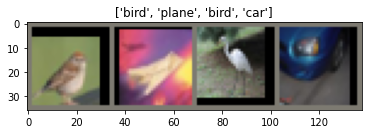

In [17]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [18]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

#############
# CODE HERE #
'''
제시된 network architecture에서는 convolution의 활성화 함수가 ReLU이고 매 convolution마다 batch-normalization을 실행한다고 나와있으므로 Conv class를 
만들었고 입력값으로 input channel의 개수와 output channel의 개수를 받는다. VGG class는 layer 별로 묶어주었다. 13개의 convolution layer를 거친다.
'''
class Conv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Conv,self).__init__()

    self.Conv_module=nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1), #kernel size, stride, padding은 항상 같다.
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )
  
  def forward(self, x):
    return self.Conv_module(x)


class VGG(nn.Module):
  def __init__(self):
    super(VGG,self).__init__()
    
    #conv1_x
    self.layer_1 = nn.Sequential(
        Conv(in_channels=3, out_channels=64),
        Conv(in_channels=64, out_channels=64),
        nn.MaxPool2d(kernel_size=2, stride=2) #pool1
    )

    #conv2_x
    self.layer_2=nn.Sequential(
        Conv(in_channels=64, out_channels=128),
        Conv(in_channels=128, out_channels=128),
        nn.MaxPool2d(kernel_size=2, stride=2) #pool2
    )

    #conv3_x
    self.layer_3=nn.Sequential(
        Conv(in_channels=128, out_channels=256),
        Conv(in_channels=256, out_channels=256),
        Conv(in_channels=256, out_channels=256),
        nn.MaxPool2d(kernel_size=2, stride=2) #pool3
    )

    #conv4_x
    self.layer_4=nn.Sequential(
        Conv(in_channels=256, out_channels=512),
        Conv(in_channels=512, out_channels=512),
        Conv(in_channels=512, out_channels=512),
        nn.MaxPool2d(kernel_size=2, stride=2) #pool4
    )
    
    #conv5_x
    self.layer_5=nn.Sequential(
        Conv(in_channels=512, out_channels=512),
        Conv(in_channels=512, out_channels=512),
        Conv(in_channels=512, out_channels=512),
        nn.MaxPool2d(kernel_size=2, stride=2) #pool5
    )

    #3-d fc
    self.fc=nn.Linear(in_features=1*1*512, out_features=3)

  def forward(self,x):
    x=self.layer_1(x)
    x=self.layer_2(x)
    x=self.layer_3(x)
    x=self.layer_4(x)
    x=self.layer_5(x)

    #차원 재구성
    x=x.view(x.size(0),-1)

    x=self.fc(x)
    return x

#############


STEP 3: CREATE MODEL CLASS (VGG16)


In [19]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14724675


VGG(
  (layer_1): Sequential(
    (0): Conv(
      (Conv_module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): Conv(
      (Conv_module): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv(
      (Conv_module): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): Conv(
      (Conv_module): Sequential(
        (0

In [20]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [22]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

#############
for epoch in range(num_epochs):
    start_time=time.time()
    for i, (images, labels) in enumerate(train_loader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device)
        labels = labels.to(device)

        # gradient 값 0으로 초기화
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Loss 계산: cross entropy loss
        loss = criterion(outputs, labels)

        # back propagation을 통해 gradient 계산
        loss.backward()

        # parameters 업데이트
        optimizer.step()

  # Accuracy 계산         
    correct = 0
    total = 0
    # test data에 model 적용 
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # maximum value에서 prediction을 가져온다.
        _, predicted = torch.max(outputs.data, 1)

        # 특정 label의 데이터 총 개수
        total += labels.size(0)

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()
        
    accuracy = 100 * correct.item() / total
    end_time=time.time()

    # Loss 출력
    print('Epochs: {}. Loss: {}. Accuracy: {}. Elapsed time: {} sec'.format(epoch, loss.item(), accuracy, (end_time - start_time)))
#############



STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.5151411294937134. Accuracy: 86.8. Elapsed time: 3.696938991546631 sec
Epochs: 1. Loss: 0.10738211125135422. Accuracy: 88.6. Elapsed time: 3.677814245223999 sec
Epochs: 2. Loss: 0.1500627100467682. Accuracy: 90.13333333333334. Elapsed time: 3.6383004188537598 sec
Epochs: 3. Loss: 0.4819418489933014. Accuracy: 91.86666666666666. Elapsed time: 3.6391115188598633 sec
Epochs: 4. Loss: 0.208445206284523. Accuracy: 91.8. Elapsed time: 3.6510822772979736 sec
Epochs: 5. Loss: 0.24878430366516113. Accuracy: 91.76666666666667. Elapsed time: 3.6610074043273926 sec
Epochs: 6. Loss: 0.48611268401145935. Accuracy: 91.76666666666667. Elapsed time: 3.666128396987915 sec
Epochs: 7. Loss: 0.0026200460270047188. Accuracy: 92.86666666666666. Elapsed time: 3.6646671295166016 sec
Epochs: 8. Loss: 0.004565310198813677. Accuracy: 92.2. Elapsed time: 3.674616575241089 sec
Epochs: 9. Loss: 0.2960062623023987. Accuracy: 91.03333333333333. Elapsed time: 3.682311534881592 

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1l3rC40WnBXZBagFIuME48SPvcqVY-56Y" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="http://drive.google.com/uc?export=view&id=1r92UcNqn6ZT5pOk3emEijjTKlWdAYvCk" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="http://drive.google.com/uc?export=view&id=1n0NYyWWbDBd9PHjNEs7AHpOhMci5q6qk" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br> 
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br> 
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points] 

In [34]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')
#############
"""
이번엔 bottlenectk block을 class로 만들어주었다. input channel의 개수, block 중간에서의 channel의 개수, output channel의 개수, channel개수가
늘어나는 지에 대한 여부, downsample이 되는지에 대한 여부를 인자로 받아서 if 문을 사용해 상황에 따라 block이 바뀌게 했다.
"""

class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels, expand_channels=False, downsample=False):
    super(BottleneckBlock,self).__init__()
    self.expand_channels=expand_channels

    if downsample:  #downsample일 때는 stride가 2
      downsample_stride=2
    else:
      downsample_stride=1

    if expand_channels: #channel이 expand할 때는 residual이 다음과 같은 convolution layer를 거치게 해야 한다.
      self.Conv1x1_res=nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=downsample_stride, padding=0)
      self.BN_res=nn.BatchNorm2d(num_features=out_channels)

    self.left_block = nn.Sequential(  #주어진 그림의 왼쪽 block
            nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=1, stride=downsample_stride, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels)
            ) 
    self.relu=nn.ReLU(inplace=True)

  def forward(self,x):
    res=x

    if self.expand_channels:
            res = self.Conv1x1_res(res)
            res = self.BN_res(res)
    x=self.left_block(x)
    x=x+res

    x=self.relu(x)
    return x

class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()

    #conv1
    self.layer_1=nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(inplace=True)
    )

    #conv2_x
    self.layer_2=nn.Sequential(
        BottleneckBlock(in_channels=64,mid_channels=64,out_channels=256, expand_channels=True, downsample=False),
        BottleneckBlock(in_channels=256,mid_channels=64,out_channels=256, expand_channels=False, downsample=False),
        BottleneckBlock(in_channels=256,mid_channels=64,out_channels=256, expand_channels=False, downsample=False),
    )

    #conv3_x
    self.layer_3=nn.Sequential(
        BottleneckBlock(in_channels=256,mid_channels=128,out_channels=512, expand_channels=True, downsample=True),
        BottleneckBlock(in_channels=512,mid_channels=128,out_channels=512, expand_channels=False, downsample=False),
        BottleneckBlock(in_channels=512,mid_channels=128,out_channels=512, expand_channels=False, downsample=False),
        BottleneckBlock(in_channels=512,mid_channels=128,out_channels=512, expand_channels=False, downsample=False)
    )

    #conv4_x
    self.layer_4=nn.Sequential(
        BottleneckBlock(in_channels=512,mid_channels=256,out_channels=1024, expand_channels=True, downsample=True),
        BottleneckBlock(in_channels=1024,mid_channels=256,out_channels=1024, expand_channels=False, downsample=False),
        BottleneckBlock(in_channels=1024,mid_channels=256,out_channels=1024, expand_channels=False, downsample=False),
        BottleneckBlock(in_channels=1024,mid_channels=256,out_channels=1024, expand_channels=False, downsample=False),
        BottleneckBlock(in_channels=1024,mid_channels=256,out_channels=1024, expand_channels=False, downsample=False),
        BottleneckBlock(in_channels=1024,mid_channels=256,out_channels=1024, expand_channels=False, downsample=False)
    )

    #conv5_x
    self.layer_5=nn.Sequential(
        BottleneckBlock(in_channels=1024,mid_channels=512,out_channels=2048, expand_channels=True, downsample=True),
        BottleneckBlock(in_channels=2048,mid_channels=512,out_channels=2048, expand_channels=False, downsample=False),
        BottleneckBlock(in_channels=2048,mid_channels=512,out_channels=2048, expand_channels=False, downsample=False)
    )
    
    #average pool, 3-d fc
    self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc_3d = nn.Linear(in_features=1*1*2048, out_features=3)

  def forward(self,x):
    x=self.layer_1(x)
    x=self.layer_2(x)
    x=self.layer_3(x)
    x=self.layer_4(x)
    x=self.layer_5(x)
    x=self.avg_pooling(x)
    x=x.view(x.size(0),-1)
    x=self.fc_3d(x)
    
    return x
    
#############

    
print('STEP 4: INSTANTIATE MODEL CLASS')
#############
model = ResNet()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
#############


STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  23533059


ResNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer_2): Sequential(
    (0): BottleneckBlock(
      (Conv1x1_res): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (BN_res): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (left_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

### 2.2 Print test accuracy for every epochs. [1 points]

In [35]:
print('STEP 5: INSTANTIATE LOSS CLASS')
#############
criterion = nn.CrossEntropyLoss()   #cross entropy loss
#############

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
#############
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4
#SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)
#############

print('STEP 7: TRAIN THE MODEL')
#############
num_epochs=15
for epoch in range(num_epochs):
    start_time=time.time()
    for i, (images, labels) in enumerate(train_loader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device)
        labels = labels.to(device)

        # gradient 값 0으로 초기화
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Loss 계산: cross entropy loss
        loss = criterion(outputs, labels)

        # back propagation을 통해 gradient 계산
        loss.backward()

        # parameters 업데이트
        optimizer.step()

  # Accuracy 계산                  
    correct = 0
    total = 0
    # test data에 model 적용
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # maximum value에서 prediction을 가져온다.
        _, predicted = torch.max(outputs.data, 1)

        # 특정 label의 데이터 총 개수
        total += labels.size(0)

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()
        
    accuracy = 100 * correct.item() / total
    end_time=time.time()

    # Loss 출력
    print('Epochs: {}. Loss: {}. Accuracy: {}. Elapsed time: {} sec'.format(epoch, loss.item(), accuracy, (end_time - start_time)))
#############


STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 0.44609665870666504. Accuracy: 71.5. Elapsed time: 19.663933753967285 sec
Epochs: 1. Loss: 0.5227960348129272. Accuracy: 76.66666666666667. Elapsed time: 19.90632152557373 sec
Epochs: 2. Loss: 1.2070974111557007. Accuracy: 79.93333333333334. Elapsed time: 20.09141182899475 sec
Epochs: 3. Loss: 0.4057813882827759. Accuracy: 81.23333333333333. Elapsed time: 20.226017236709595 sec
Epochs: 4. Loss: 0.574047863483429. Accuracy: 82.06666666666666. Elapsed time: 20.32991623878479 sec
Epochs: 5. Loss: 0.6026892066001892. Accuracy: 83.73333333333333. Elapsed time: 20.423381805419922 sec
Epochs: 6. Loss: 0.3337309658527374. Accuracy: 84.03333333333333. Elapsed time: 20.445915699005127 sec
Epochs: 7. Loss: 0.22657275199890137. Accuracy: 83.16666666666667. Elapsed time: 20.512145042419434 sec
Epochs: 8. Loss: 0.25008174777030945. Accuracy: 84.3. Elapsed time: 20.53226613998413 sec
Epochs: 9.

결과를 살펴보면, VGGNet은 epochs 19에서 최대 accuracy인데 92.97이 나왔고 ResNet은 epochs 13에서 최대 accuracy가 나왔고 86.6이 나왔다. ResNet의 accuracy가 증가하는 폭으로 보아 epochs를 똑같이 설정해도 VGGNet만큼의 accuracy가 나오지 않을 것이라고 추정할 수 있다. 그러나, 논문을 보면 VGGNet의 accuracy가 ResNet보다 낮은 것을 볼 수 있다. 이러한 차이가 생기는 이유는 ImageNet에 비해 매우 작은 dataset을 사용했는데 이에 의한 overfitting이라고 추정할 수 있다. 실제로 loss는 매우 작지만 accuracy는 86.6에 그치는 모습을 볼 수 있다. 혹시 적은 epoch이 이유일까 싶어 epoch을 30으로 설정하고 추가 실험을 해보았으나 accuracy는 epoch 17에서 89.0, epoch 26에서 89.2일 정도로 epoch가 증가해도 거의 늘지 않았고 loss는 epoch 23이후에는 0.015이하를 유지할 정도로 loss가 줄어들었다. 따라서 overfitting 때문일 것이라는 추측에 힘을 실어준다.  parameter의 개수는 VGGNet이 14724675개, ResNet이 23533059개로 ResNet이 더 많은 것을 확인할 수 있다. ResNet이 layer의 개수가 훨씬 많기 때문에 train하는데 VGGNet보다 많은 시간이 걸린다.